# Practing K-Mean clustering (2012 to 2021 so fare!)
## Goal: Try to put the all the musicians into clusters. Singer/songwriter, Featuring Artist, songwriter etc.
## Expectations: Very big cluster with the 'average' artists/writers. Smallish Cluster with Big stars.  And one very small cluster with super star!
Might introduce another feature called number of top 10 songs or something like that. Genres maybe

In [1]:
import pandas as pd
df = pd.read_csv('data/artist_1992_2021_test.csv')
df


,Name,Main Artist,Featuring Artist,Writer
0,'N Sync,8,1,0
1,"10,000 Maniacs",1,0,0
2,112,6,2,0
3,2 Chainz,2,2,0
4,2 Pistols,1,0,0
...,...,...,...,...
3318,iLoveMemphis,1,0,0
3319,soFLY & Nius,0,0,1
3320,soulDecision,1,0,0
3321,will.i.am,2,5,2


### 1. Exploring the Dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              3323 non-null   object
 1   Main Artist       3323 non-null   int64 
 2   Featuring Artist  3323 non-null   int64 
 3   Writer            3323 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 104.0+ KB


In [3]:
df.describe()

,Main Artist,Featuring Artist,Writer
count,3323.000000,3323.000000,3323.000000
mean,0.903701,0.253987,1.617514
std,2.402787,1.094240,3.041102
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,1.000000,0.000000,2.000000
max,35.000000,27.000000,63.000000


In [4]:
from sklearn.preprocessing import StandardScaler as SS # z-score standardization 
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer

In [5]:
#pip install yellowbrick

In [15]:
def silhouettePlot(range_, data):
    '''
    we will use this function to plot a silhouette plot that helps us to evaluate the cohesion in clusters (k-means only)
    '''
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()
    #fig.savefig("silhouette_plot.png")

In [16]:
def elbowPlot(range_, data, figsize=(10,10)):
    '''
    the elbow plot function helps to figure out the right amount of clusters for a dataset
    '''
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
        
    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    #fig.savefig("elbow_plot.png")


In [17]:
def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN; based on this article: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [8]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    '''
    very basic implementation of an algorithm for feature selection (unsupervised clustering); inspired by this post: https://datascience.stackexchange.com/questions/67040/how-to-do-feature-selection-for-clustering-and-implement-it-in-python
    '''
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

### Standardized

In [9]:
scaler = SS()
DNP_artists_standardized = scaler.fit_transform(df.drop("Name",axis=1))
df_artists_standardized = pd.DataFrame(DNP_artists_standardized, columns=["main_artist_standardized","featuring_artist_standardized","songwriter_standardized"])
df_artists_standardized = df_artists_standardized.set_index(df.index)

In [10]:
df_artists_standardized

,main_artist_standardized,featuring_artist_standardized,songwriter_standardized
0,2.953806,0.681866,-0.531964
1,0.040084,-0.232148,-0.531964
2,2.121314,1.595880,-0.531964
3,0.456330,1.595880,-0.531964
4,0.040084,-0.232148,-0.531964
...,...,...,...
3318,0.040084,-0.232148,-0.531964
3319,-0.376162,-0.232148,-0.203087
3320,0.040084,-0.232148,-0.531964
3321,0.456330,4.337921,0.125791


### Find the best 3(or more) features. OBS.: Right now i only have 3. So there is no point in doing it..

In [11]:
selected_features = progressiveFeatureSelection(df_artists_standardized, max_features=3, n_clusters=3)

Proposed new feature main_artist_standardized with score 0.8383288573923636
Proposed new feature featuring_artist_standardized with score 0.9191937178432104
Proposed new feature songwriter_standardized with score 0.7967302691384183
The initial feature is featuring_artist_standardized with a silhouette score of 0.9191937178432104.
Starting selection 0...
Proposed new feature main_artist_standardized with score 0.8375289612807093
Proposed new feature songwriter_standardized with score 0.8394399230395532
Selected new feature songwriter_standardized with score 0.8394399230395532
Starting selection 1...
Proposed new feature main_artist_standardized with score 0.7333784225142838
Selected new feature main_artist_standardized with score 0.7333784225142838


In [12]:
# slice it into a new dataframe
df_standardized_sliced = df_artists_standardized[selected_features]

## Choosing the Right Amount of Clusters

/tmp/ipykernel_472/817249690.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


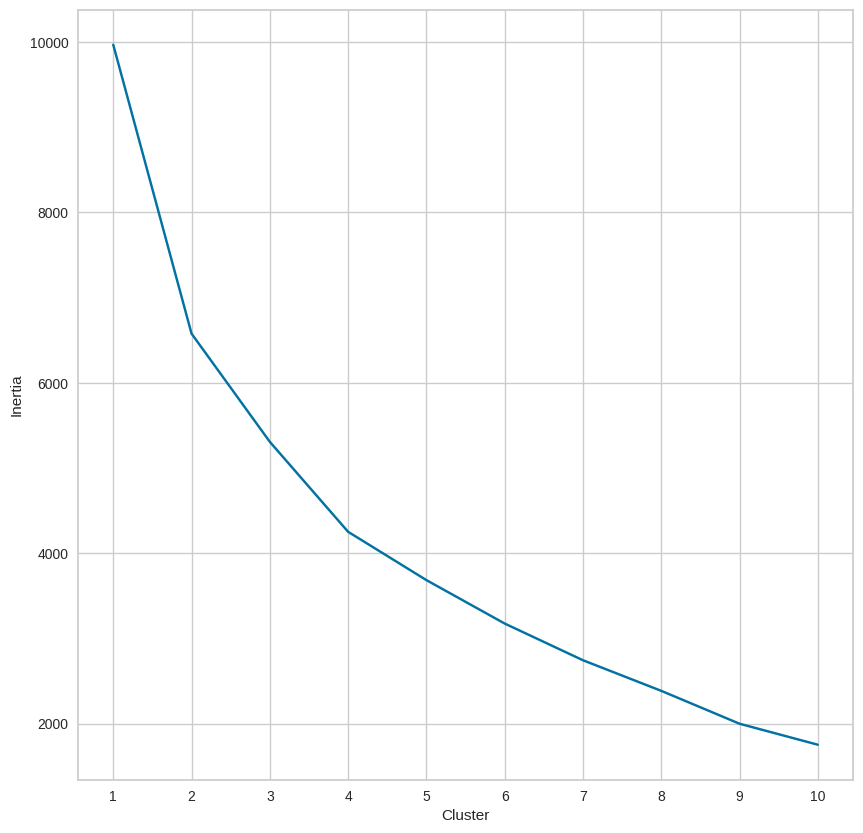

In [18]:
elbowPlot(range(1,11), df_standardized_sliced)

- The elbow is bending at about x clusters.

/tmp/ipykernel_472/2866924435.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


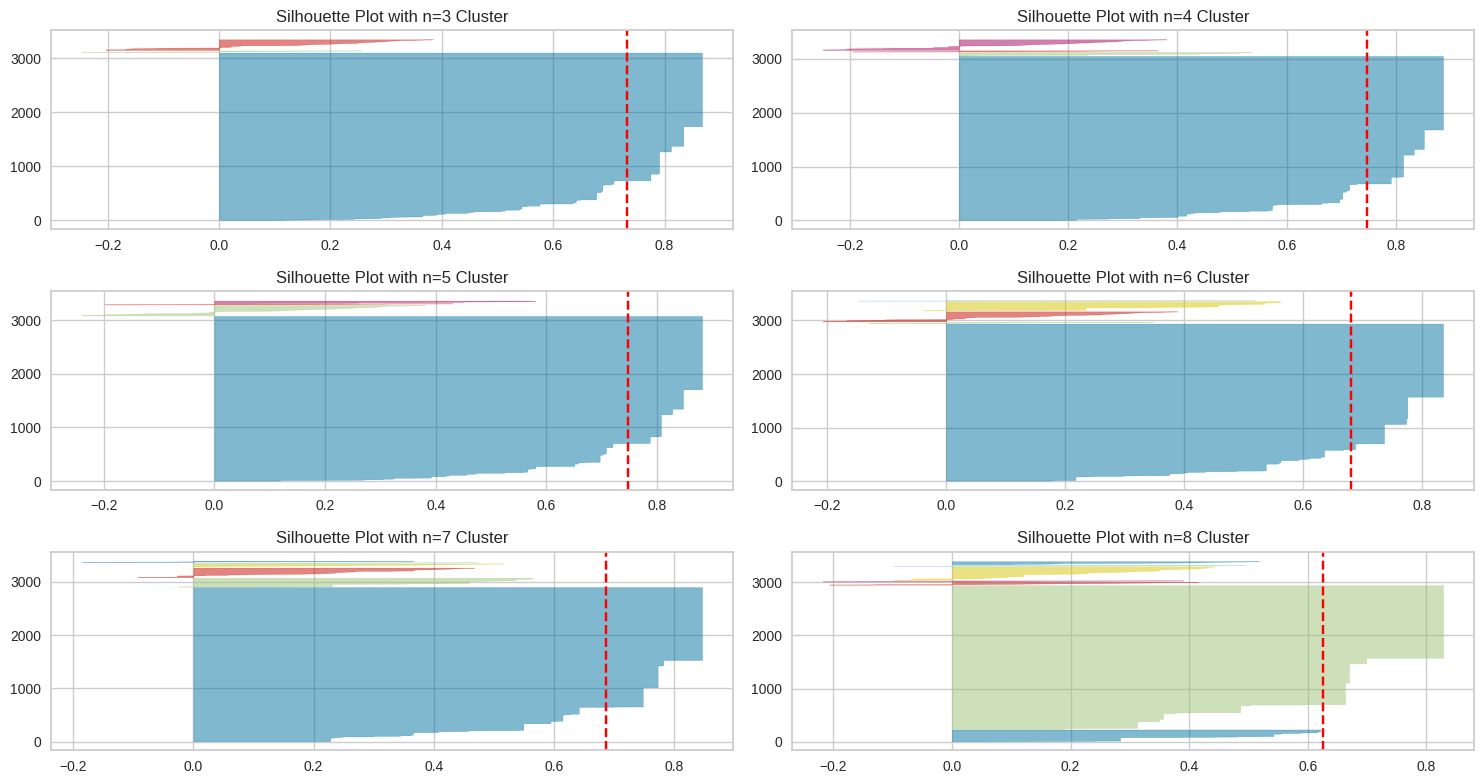

In [19]:
silhouettePlot(range(3,9), df_standardized_sliced)

- All have a silhouette score above 6. But 4-5 clusters still seems to have the highest. But i might go with 6, 7 or 8. Because of the way the 'knifes' looks.

/tmp/ipykernel_472/2870745032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_sliced["clusters"] = cluster_labels


<AxesSubplot: xlabel='pc_1', ylabel='pc_2'>

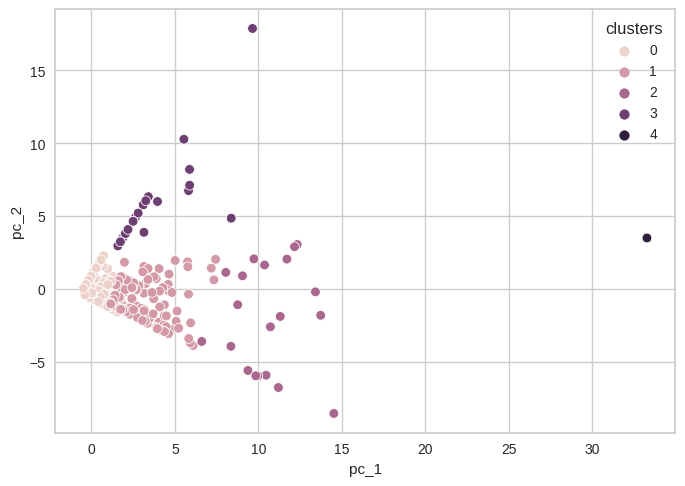

In [20]:
clusters = 5

# Not sure what the random_state is. "..the parameter allows us to reproduce our results..."
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized_sliced)
df_standardized_sliced["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
authors_standardized_pca = pca.fit_transform(df_standardized_sliced)
df_authors_standardized_pca = pd.DataFrame(data=authors_standardized_pca, columns=["pc_1", "pc_2"])
df_authors_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_authors_standardized_pca)

In [22]:
df_authors_standardized_pca

,pc_1,pc_2,clusters
0,2.167008,-1.600595,1
1,-0.386877,-0.399557,0
2,2.210753,-1.645321,1
3,0.966100,-1.204839,0
4,-0.386877,-0.399557,0
...,...,...,...
3318,-0.386877,-0.399557,0
3319,-0.487722,0.025186,0
3320,-0.386877,-0.399557,0
3321,3.152690,-1.502676,1


In [23]:
cluster_df = df_standardized_sliced[["clusters"]]

In [24]:
df_clustered_data = pd.merge(df , cluster_df, left_index=True, right_index=True)
df_clustered_data

,Name,Main Artist,Featuring Artist,Writer,clusters
0,'N Sync,8,1,0,1
1,"10,000 Maniacs",1,0,0,0
2,112,6,2,0,1
3,2 Chainz,2,2,0,0
4,2 Pistols,1,0,0,0
...,...,...,...,...,...
3318,iLoveMemphis,1,0,0,0
3319,soFLY & Nius,0,0,1,0
3320,soulDecision,1,0,0,0
3321,will.i.am,2,5,2,1


In [25]:
#
df_clustered_data[df_clustered_data['clusters'] == 0]

,Name,Main Artist,Featuring Artist,Writer,clusters
1,"10,000 Maniacs",1,0,0,0
3,2 Chainz,2,2,0,0
4,2 Pistols,1,0,0,0
5,20 Fingers,1,0,0,0
7,24kGoldn,2,0,0,0
...,...,...,...,...,...
3317,busbee,0,0,2,0
3318,iLoveMemphis,1,0,0,0
3319,soFLY & Nius,0,0,1,0
3320,soulDecision,1,0,0,0


In [26]:
# Medium sized artists
df_clustered_data[df_clustered_data['clusters'] == 1]

,Name,Main Artist,Featuring Artist,Writer,clusters
0,'N Sync,8,1,0,1
2,112,6,2,0,1
6,21 Savage,2,4,0,1
8,2Pac,6,1,0,1
9,3 Doors Down,8,0,0,1
...,...,...,...,...,...
3286,Ying Yang Twins,2,3,0,1
3293,Young Jeezy,4,1,1,1
3295,Young Thug,2,7,0,1
3313,Zedd,4,1,0,1


In [27]:
# 
df_clustered_data[df_clustered_data['clusters'] == 2]

,Name,Main Artist,Featuring Artist,Writer,clusters
83,Akon,8,11,3,2
124,Alicia Keys,12,5,16,2
232,Ariana Grande,20,4,11,2
333,Beyoncé,20,3,21,2
468,Bruno Mars,11,7,17,2
608,Chris Brown,23,10,17,2
1454,Jay-Z,16,10,0,2
1700,Justin Bieber,15,12,21,2
1735,Kanye West,13,9,28,2
1924,Lil Wayne,11,14,1,2


In [28]:
# 
df_clustered_data[df_clustered_data['clusters'] == 3]

,Name,Main Artist,Featuring Artist,Writer,clusters
60,Adam Levine,0,3,27,3
122,Aliaune Thiam,0,0,12,3
249,Ashley Gorley,0,0,11,3
260,Austin Post,0,0,11,3
284,Babyface,4,1,28,3
305,Belcalis Almánzar,0,0,10,3
323,Benjamin Levin,0,0,12,3
504,Calvin Broadus,0,0,13,3
566,Chad Kroeger,1,1,15,3
635,Christopher Bridges,0,0,17,3


In [29]:
# 
df_clustered_data[df_clustered_data['clusters'] == 4]

,Name,Main Artist,Featuring Artist,Writer,clusters
943,Drake,35,27,61,4


In [30]:
df_clustered_data[df_clustered_data['clusters'] == 5]

,Name,Main Artist,Featuring Artist,Writer,clusters


In [43]:
#
df_clustered_data[df_clustered_data['clusters'] == 6]

,Name,Main Artist,Featuring Artist,Writer,clusters


# Other tutorial  (Not as good)
https://towardsdatascience.com/clustering-with-more-than-two-features-try-this-to-explain-your-findings-b053007d680a

In [6]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 7.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:

import plotly.express as px
fig = px.scatter_matrix(df.drop("Name",axis=1),
width=950, height=1200)
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [18]:
# Somethings wrong with this. color and size
fig1 = px.scatter(df, x="Main Artist", y="Featuring Artist", color="Writer",
                 size="Main Artist")
fig1.update_layout(title="4 Features Representation")
fig1.show()

### Find the optimal amount of clusters

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import numpy as np
X=df.drop("Name",axis=1)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
fig = go.Figure(data=go.Scatter(x=np.arange(1,11),y=inertia))
fig.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,11],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
        dict(
            x=3,
            y=inertia[2],
            xref="x",
            yref="y",
            text="Elbow!",
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40
        )
    ])

In [21]:
pie=clusters.groupby('label').size().reset_index()
pie.columns=['label','value']
px.pie(pie,values='value',names='label',color=['blue','red','green'])

#### Not the result i had expected. Need more research